In [77]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from scipy import stats
from scipy.stats import norm,skew
import warnings
from sklearn.preprocessing import RobustScaler
warnings.filterwarnings("ignore")
%matplotlib inline
# MinMaxScaler用於數據的歸一化
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import r2_score

# 讀取數據

data_path = r'C:\Users\rex\Desktop\水位預測\2\總整理.csv'
data = pd.read_csv(data_path)

print (data)
data.head(5)



             Date   Time  1510H084 Water Level  1510H076 Water Level  \
0        2020/1/1  00:00                145.30                  5.03   
1        2020/1/1  01:00                145.30                  5.11   
2        2020/1/1  02:00                145.30                  5.11   
3        2020/1/1  03:00                145.30                  5.11   
4        2020/1/1  04:00                145.30                  5.11   
...           ...    ...                   ...                   ...   
26299  2022/12/31  19:00                143.63                  4.69   
26300  2022/12/31  20:00                143.63                  4.69   
26301  2022/12/31  21:00                143.63                  4.70   
26302  2022/12/31  22:00                143.64                  4.70   
26303  2022/12/31  23:00                143.63                  4.70   

       1510H071 Water Level  1510H057 Water Level  19774 Rainfall  \
0                     20.58                 88.47             0.0 

,Date,Time,1510H084 Water Level,1510H076 Water Level,1510H071 Water Level,1510H057 Water Level,19774 Rainfall,20016 Rainfall,19606 Rainfall,19335 Rainfall
0,2020/1/1,00:00,145.3,5.03,20.58,88.47,0.0,0.0,0.0,0.000000
1,2020/1/1,01:00,145.3,5.11,20.80,88.79,0.0,0.0,0.0,0.000000
2,2020/1/1,02:00,145.3,5.11,20.81,88.78,0.0,0.0,0.0,0.000000
3,2020/1/1,03:00,145.3,5.11,20.80,88.84,0.0,0.0,0.0,0.000000
4,2020/1/1,04:00,145.3,5.11,20.79,88.81,0.0,0.0,0.0,1.428012


In [78]:
import sys
print(sys.executable)

c:\Users\rex\Anaconda3\envs\tf-GPU\python.exe


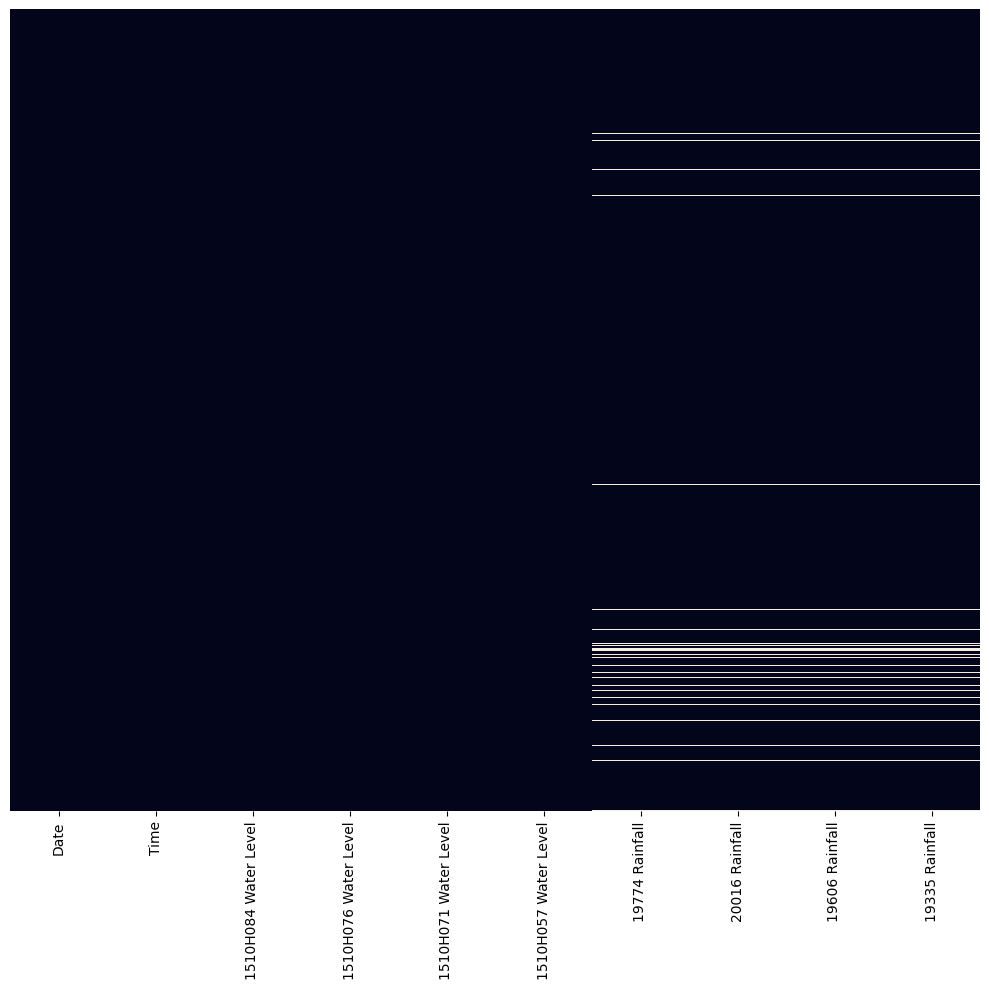

In [79]:
#isnull()看數據缺失值
plt.figure(figsize=(10,10))
sns.heatmap(data.isnull(), yticklabels=False, cbar=False)
plt.tight_layout()
plt.show()

In [80]:
data = data.fillna(0)

In [81]:
#看數據維度
print(data.shape)
#看數據訊息
data.info()

(26304, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  26304 non-null  object 
 1   Time                  26304 non-null  object 
 2   1510H084 Water Level  26304 non-null  float64
 3   1510H076 Water Level  26304 non-null  float64
 4   1510H071 Water Level  26304 non-null  float64
 5   1510H057 Water Level  26304 non-null  float64
 6   19774 Rainfall        26304 non-null  float64
 7   20016 Rainfall        26304 non-null  float64
 8   19606 Rainfall        26304 non-null  float64
 9   19335 Rainfall        26304 non-null  float64
dtypes: float64(8), object(2)
memory usage: 2.0+ MB


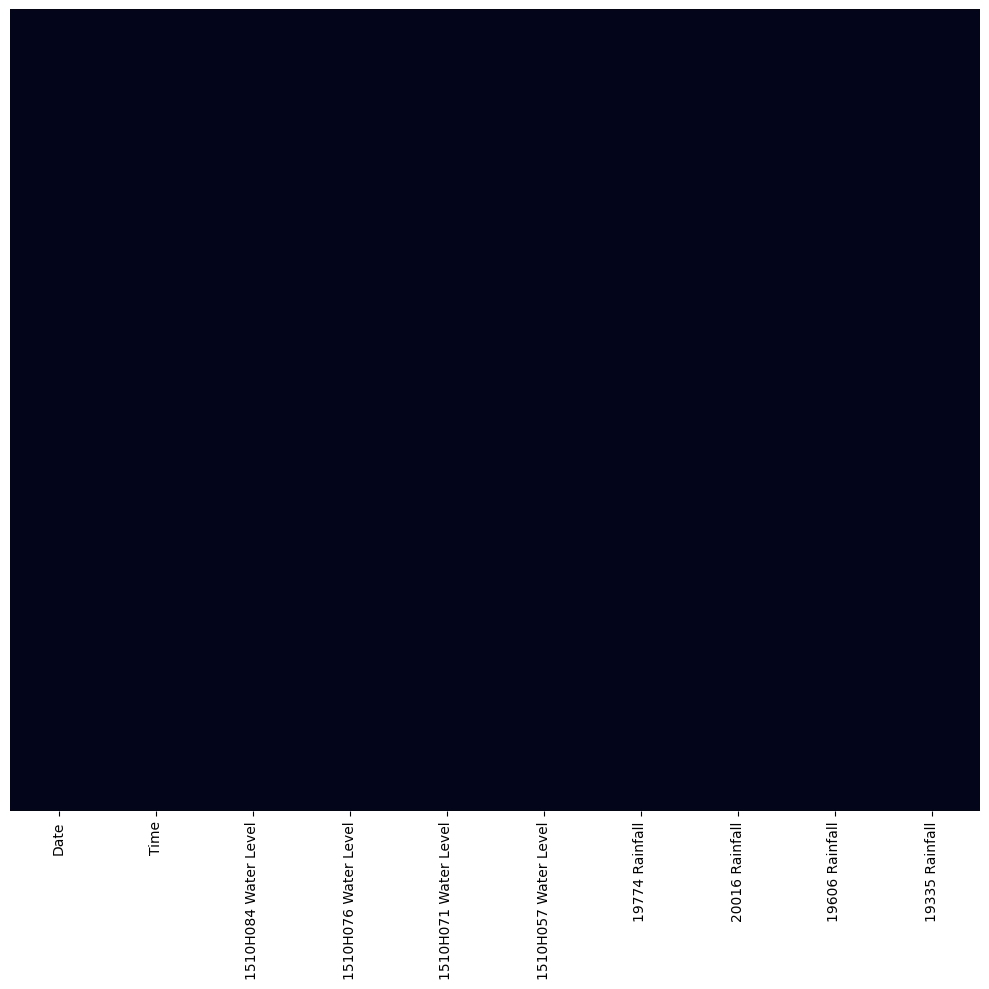

In [82]:
#isnull()看數據缺失值
plt.figure(figsize=(10,10))
sns.heatmap(data.isnull(), yticklabels=False, cbar=False)
plt.tight_layout()
plt.show()


mu = 0.18 and sigma = 0.14


mu = 0.29 and sigma = 0.10


mu = 0.30 and sigma = 0.16


mu = 0.17 and sigma = 0.14



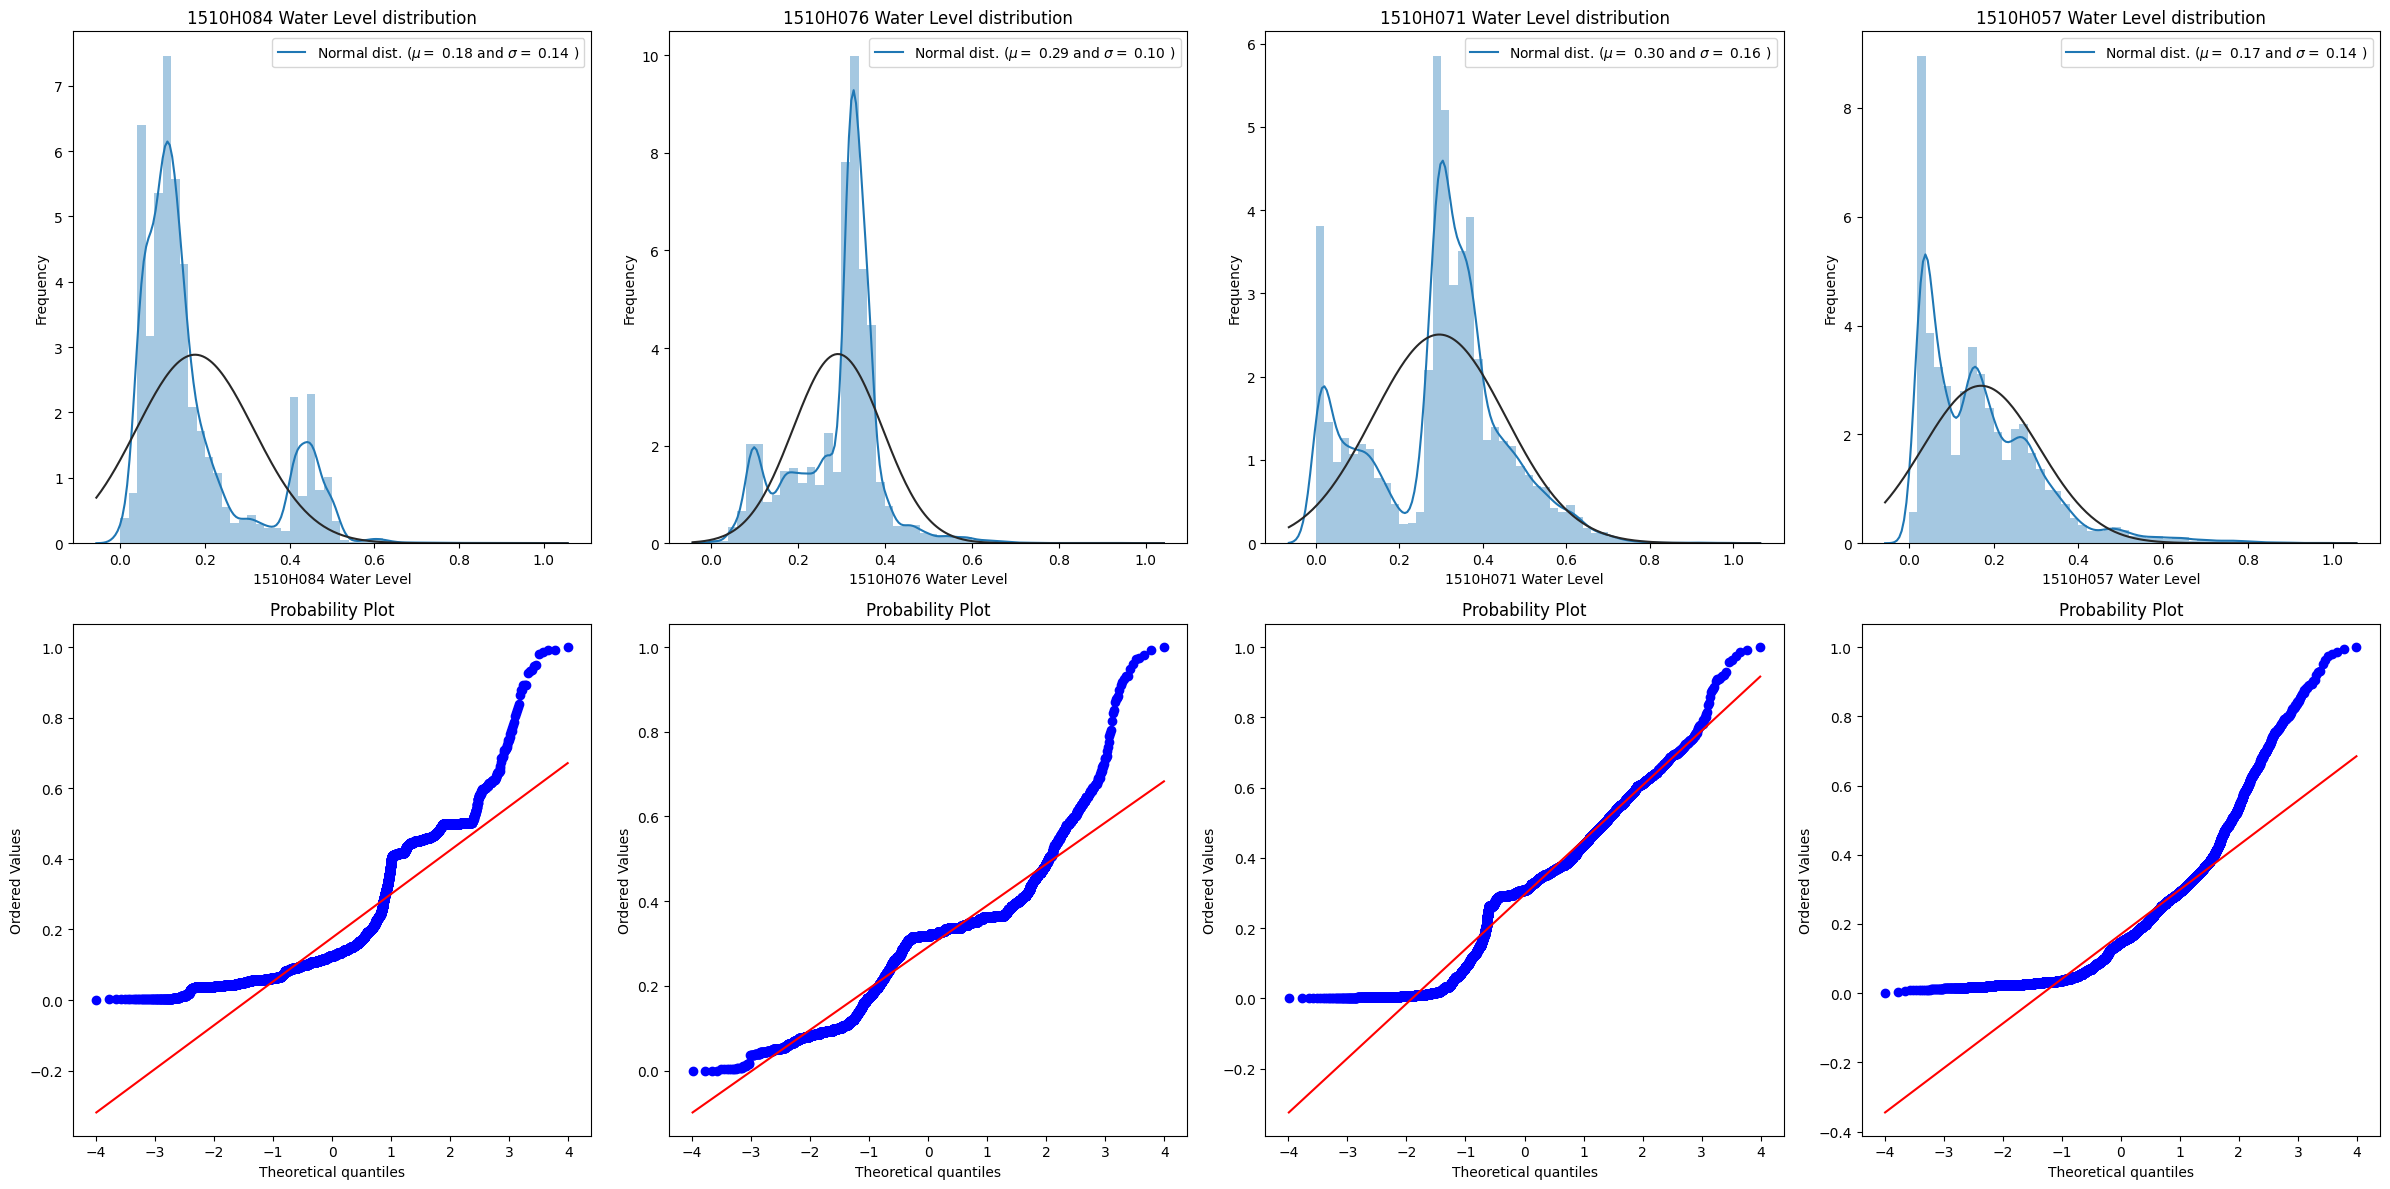

In [83]:

# 分析目標變量的分布，計算均值與標準差
targets = ["1510H084 Water Level", "1510H076 Water Level", "1510H071 Water Level", "1510H057 Water Level"]

fig, axs = plt.subplots(2, 4, figsize=(24, 12))  # 創建一個包含8個子圖的圖形窗口

for i, target in enumerate(targets):
    
    # 繪製概率密度函數和核密度估計的圖
    sns.distplot(train[target], fit=norm, ax=axs[0, i])   # 將圖繪製在適當的子圖上
    
    (mu, sigma) = norm.fit(train[target])   # 對變量進行最大似然估計
    print('\nmu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    
    axs[0, i].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
    axs[0, i].set_ylabel('Frequency')
    axs[0, i].set_title('{} distribution'.format(target))
    
    # 繪製概率圖
    stats.probplot(train[target], plot=axs[1, i])   # 將圖繪製在適當的子圖上

plt.tight_layout()  # 自動調整子圖的佈局，使之填滿整個圖形窗口
plt.show()


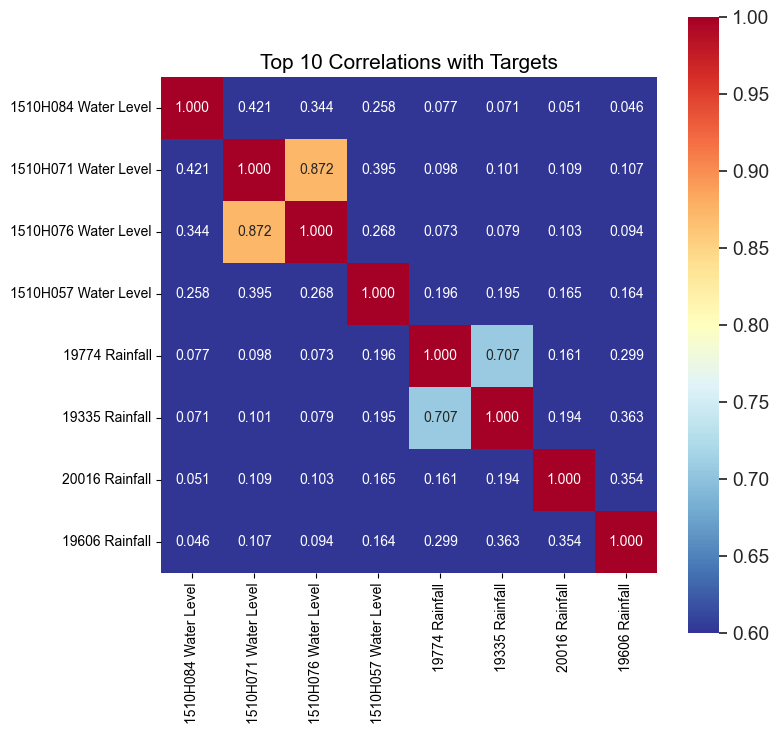

In [85]:
k = 10
corrmat = train.corr()
cols = corrmat.nlargest(k, targets)[targets].index
cm = np.corrcoef(train[cols].values.T)

fig, ax = plt.subplots(figsize=(8, 8))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.3f', annot_kws={'size':10},
            yticklabels=cols.values, xticklabels=cols.values, cmap='RdYlBu_r', vmin=0.6, vmax=1.0)
plt.title(f"Top {k} Correlations with Targets")
plt.show()


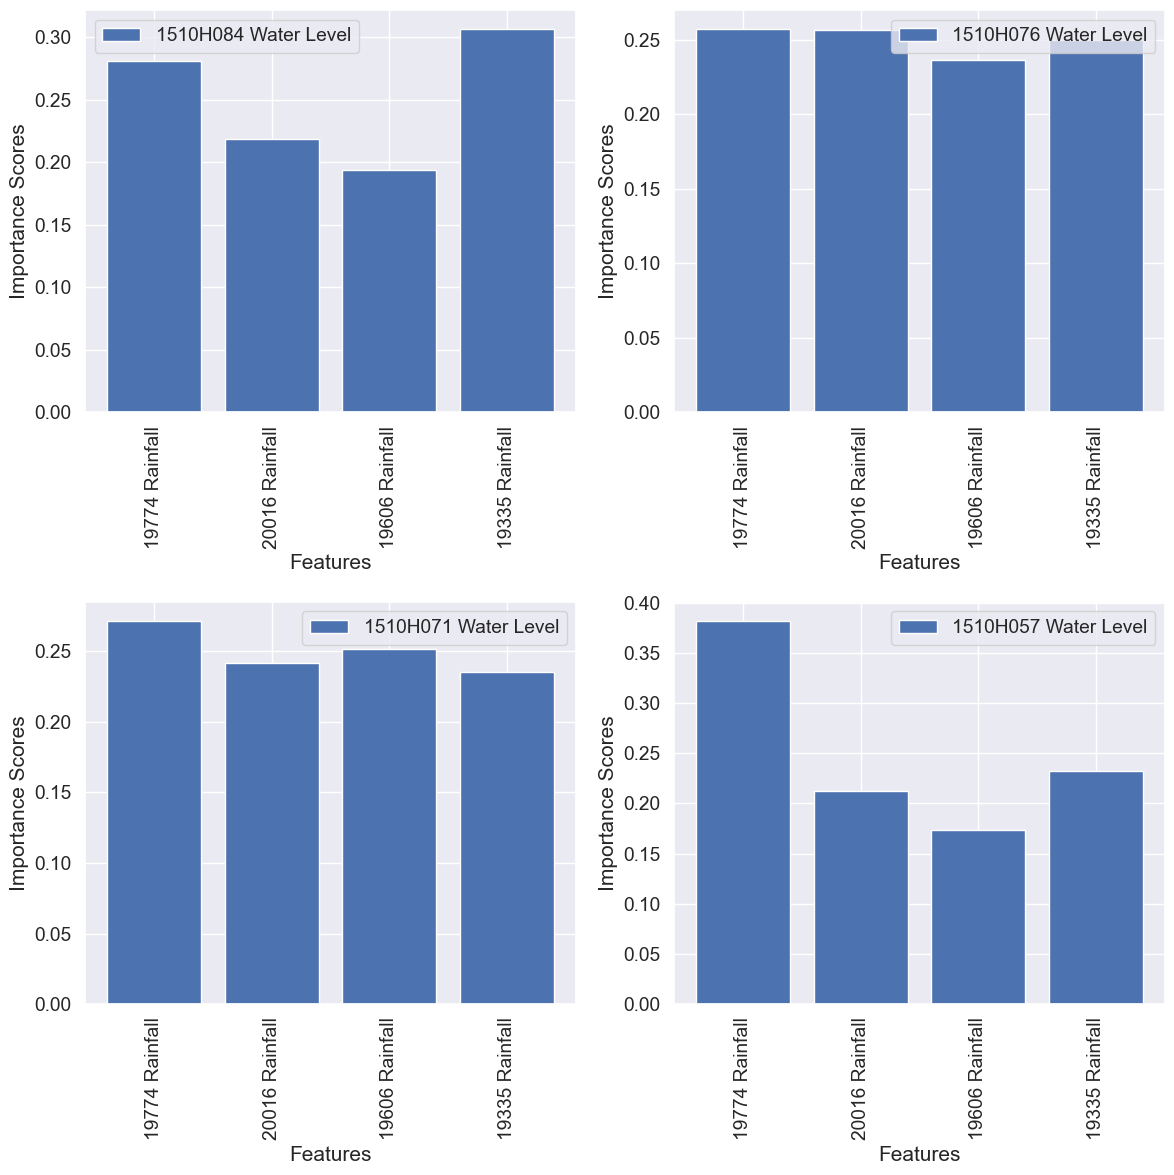

In [87]:
#隨機森林塞選變

# 準備特徵和目標變量
features = ["19774 Rainfall", "20016 Rainfall", "19606 Rainfall", "19335 Rainfall"]

targets = ["1510H084 Water Level", "1510H076 Water Level", "1510H071 Water Level", "1510H057 Water Level"]  # 目標變量

target_1510H084 = train["1510H084 Water Level"]
target_1510H076 = train["1510H076 Water Level"]
target_1510H071 = train["1510H071 Water Level"]
target_1510H057 = train["1510H057 Water Level"]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for i, target in enumerate(targets):
    row = i // 2
    col = i % 2

    # 創建特徵和目標變量的數據集
    X = train[features]
    y = train[target]

    # 构建随機森林模型
    model = RandomForestRegressor(n_estimators=100)

    # 訓練模型
    model.fit(X, y)

    # 提取變量重要性
    importance_scores = model.feature_importances_

    # 可視化變量重要性
    axes[row, col].bar(features, importance_scores, label=target)
    axes[row, col].set_xlabel('Features')
    axes[row, col].set_ylabel('Importance Scores')
    axes[row, col].set_xticklabels(features, rotation=90)
    axes[row, col].legend()

plt.tight_layout()
plt.show()

In [92]:
#導入
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold,cross_val_score,train_test_split,cross_val_predict
from sklearn.metrics import mean_squared_error,mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin

In [93]:
# 交叉驗證
n_folds = 5

# RMSE
def rmsle_cv(model, X, y):
    kf = KFold(n_folds, shuffle=True, random_state=42).split(X.values)
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return rmse

# MAE
def mae_cv(model, X, y):
    kf = KFold(n_folds, shuffle=True, random_state=42).split(X.values)
    mae = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=kf)
    return mae

# R-squared
def r2_cv(model, X, y):
    kf = KFold(n_folds, shuffle=True, random_state=42).split(X.values)
    r2 = cross_val_score(model, X, y, scoring="r2", cv=kf)
    return r2


In [94]:
# 用來儲存模型的字典
models_dict = {}

In [97]:

for target_name, target in zip(["1510H084 Water Level", "1510H076 Water Level", "1510H071 Water Level", "1510H057 Water Level"], [target_1510H084, target_1510H076, target_1510H071, target_1510H057]):
    print("Target:", target_name)
    
    
    train_size = 0.8
    X = train[features].loc[target.index]
    y_selected = target

    # 使用train_test_split來拆分訓練集和驗證集
    X_train, X_valid, y_train, y_valid = train_test_split(X, y_selected, train_size=train_size, random_state=1)

    # Lasso
    lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
    lasso.fit(X_train, y_train)
    
    # 在驗證集上進行預測並評估性能
    y_pred = lasso.predict(X_valid)
    
    # 更改評估函數，使之適用於驗證集
    mae = mae_cv(lasso, X_train, y_train)
    
    rmse = rmsle_cv(lasso, X_train, y_train)
    
    r2 = r2_cv(lasso, X_train, y_train)

    print("\nLasso MAE score: {:.4f} ({:.4f})\n".format(mae.mean(), mae.std()))
    
    print("\nLasso RMSE score: {:.4f} ({:.4f})\n".format(rmse.mean(), rmse.std()))
    
    print("\nLasso R^2 score: {:.4f} ({:.4f})\n".format(r2.mean(), r2.std()))
    models_dict[target_name + '_lasso'] = lasso
    
    
    #ENet
    ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
    ENet.fit(X_train, y_train)
    mae = mae_cv(ENet, X_train, y_train)
    rmse = rmsle_cv(ENet, X_train, y_train)
    r2 = r2_cv(ENet, X_train, y_train)
    print("\nElasticNet MAE score: {:.4f} ({:.4f})\n".format(mae.mean(), mae.std()))
    print("\nElasticNet RMSE score: {:.4f} ({:.4f})\n".format(rmse.mean(), rmse.std()))
    print("\nElasticNet R^2 score: {:.4f} ({:.4f})\n".format(r2.mean(), r2.std()))
    models_dict[target_name + '_ENet'] = ENet
    
    #KRR
    KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree= 2,coef0=2.5)
    KRR.fit(X_train, y_train)
    mae = mae_cv(KRR, X_train, y_train)
    rmse = rmsle_cv(KRR, X_train, y_train)
    r2 = r2_cv(KRR, X_train, y_train)
    print("\nKernel Ridge RMSE score: {:.4f} ({:.4f})\n".format(mae.mean(), mae.std()))
    print("\nKernel Ridge RMSE score: {:.4f} ({:.4f})\n".format(rmse.mean(), rmse.std()))
    print("\nKernel Ridge R^2 score: {:.4f} ({:.4f})\n".format(r2.mean(), r2.std()))
    models_dict[target_name + '_KRR'] = KRR
    
    #梯度提升
    GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                    max_depth=4, max_features='sqrt',
                                    min_samples_leaf=15, min_samples_split=10,
                                    loss='huber', random_state=5)
    GBoost.fit(X_train, y_train)
    mae = mae_cv(GBoost, X_train, y_train)
    rmse = rmsle_cv(GBoost, X_train, y_train)
    r2 = r2_cv(GBoost, X_train, y_train)
    print("\nGradient Boosting MAE score: {:.4f} ({:.4f})\n".format(mae.mean(), mae.std()))
    print("\nGradient Boosting RMSE score: {:.4f} ({:.4f})\n".format(rmse.mean(), rmse.std()))
    print("\nGradient Boosting R^2 score: {:.4f} ({:.4f})\n".format(r2.mean(), r2.std()))
    models_dict[target_name + '_GBoost'] = GBoost
    
    #XGB
    model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.4608,     # colsamples_bytree 是列的採樣率    # gamma 是節點劃分所需的最小損失減少值
                             learning_rate=0.05, max_depth=3,               # learning_rate 是每次迭代的步長大小 # max_depth 是樹的最大深度
                             min_child_weight=1.7817,n_estimators=2200,     # min_child_weight 是子節點所需最小樣本數   # n_estimators 是樹的數量
                             subsample=0.5213,                              # subsample 是行的採樣率            
                             reg_alpha=0.4640, reg_lambda=0.8571,           # reg_alpha 和 reg_lambda 是 L1 和 L2 正則化項的權重
                             random_state=7, nthread=-1)                    # nthread 是 CPU 的使用數量
    #XGBoost
    model_xgb.fit(X_train, y_train)
    mae = mae_cv(model_xgb, X_train, y_train)
    rmse = rmsle_cv(model_xgb, X_train, y_train)
    r2 = r2_cv(model_xgb, X_train, y_train)
    print("\nXgboost MAE score: {:.4f} ({:.4f})\n".format(mae.mean(), mae.std()))
    print("\nXgboost RMSE score: {:.4f} ({:.4f})\n".format(rmse.mean(), rmse.std()))
    print("\nXgboost R^2 score: {:.4f} ({:.4f})\n".format(r2.mean(), r2.std()))
    models_dict[target_name + '_xgb'] = model_xgb

    #lgb
    model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=28,
                                learning_rate=0.020000000000000004, n_estimators=700,
                                max_bin=40, subsample=0.7777777777777778, subsample_freq=3,
                                colsample_bytree= 0.7777777777777778,
                                min_child_samples=5, min_child_weight=11)

    model_lgb.fit(X_train, y_train)
    mae = mae_cv(model_lgb, X_train, y_train)
    rmse = score = rmsle_cv(model_lgb, X_train, y_train)
    r2 = r2_cv(model_lgb, X_train, y_train)
    print("\nLGB MAE score: {:.4f} ({:.4f})\n".format(mae.mean(), mae.std()))
    print("\nLGB RMSE score: {:.4f} ({:.4f})\n" .format(rmse.mean(), rmse.std()))
    print("\nLGB R^2 score: {:.4f} ({:.4f})\n".format(r2.mean(), r2.std()))
    models_dict[target_name + '_lgb'] = model_lgb

Target: 1510H084 Water Level

Lasso MAE score: 0.1065 (0.0013)


Lasso RMSE score: 0.1383 (0.0017)


Lasso R^2 score: -0.0002 (0.0002)


ElasticNet MAE score: 0.1065 (0.0013)


ElasticNet RMSE score: 0.1383 (0.0017)


ElasticNet R^2 score: -0.0002 (0.0002)


Kernel Ridge RMSE score: 0.1059 (0.0014)


Kernel Ridge RMSE score: 0.1378 (0.0018)


Kernel Ridge R^2 score: 0.0066 (0.0023)


Gradient Boosting MAE score: 0.1028 (0.0014)


Gradient Boosting RMSE score: 0.1398 (0.0017)


Gradient Boosting R^2 score: -0.0230 (0.0104)


Xgboost MAE score: 0.1060 (0.0013)


Xgboost RMSE score: 0.1377 (0.0018)


Xgboost R^2 score: 0.0084 (0.0025)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info]

In [ ]:
# data["Date"] = pd.to_datetime(data["Date"])

# data["Time"] = pd.to_datetime(data["Time"])

data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data.set_index('DateTime', inplace=True)
# data.drop(columns=['Date', 'Time'], inplace=True)


In [ ]:
!pip install statsmodels
from statsmodels.graphics.tsaplots import plot_acf
# Define the list of columns to analyze
columns_to_analyze = ["1510H084 Water Level", "1510H076 Water Level", "1510H071 Water Level", "1510H057 Water Level", "19774 Rainfall", "20016 Rainfall", "19606 Rainfall", "19335 Rainfall"]

# Create a figure and axes
fig, axs = plt.subplots(len(columns_to_analyze), figsize=(10, 20))

# Generate the autocorrelation plot for each column
for ax, column in zip(axs, columns_to_analyze):
    plot_acf(data[column], ax=ax, lags=48, title=f'Autocorrelation of {column}')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
# 合併日期和時間為單一時間戳，並設為索引
data['Timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data = data.set_index('Timestamp')

# 刪除不必要的列
data = data.drop(['Date', 'Time'], axis=1)


In [ ]:
# 歸一化數據 X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) 最小最大歸一化
scalers = {}
for i in data.columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    s_s = scaler.fit_transform(data[i].values.reshape(-1,1))
    s_s = np.reshape(s_s, len(s_s))
    scalers['scaler_'+ i] = scaler
    data[i] = s_s

In [ ]:
target_cols = ["1510H084 Water Level", "1510H076 Water Level", "1510H071 Water Level", "1510H057 Water Level"]


In [ ]:
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from math import sqrt

# 切分訓練集與測試集
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# 創建輸入序列和目標序列
time_steps = 48
X_train, y_train = create_dataset(train, train[target_cols], time_steps)
X_test, y_test = create_dataset(test, test[target_cols], time_steps)

# 定義LSTM模型
model = Sequential()
model.add(LSTM(150, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(len(target_cols)))  # 輸出層的神經元數量應與目標變量數量相同

# 調整學習率
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)

# 編譯模型
model.compile(optimizer=optimizer, loss='mse')

# 定義早停
early_stopping = EarlyStopping(monitor='val_loss', patience=5)  

# 訓練模型
history = model.fit(
    X_train, y_train,
    epochs=20,  
    batch_size=64,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
    callbacks=[early_stopping]  
)

# 進行預測
y_pred = model.predict(X_test)

# 將預測值和實際值的縮放反轉回來
for i in range(len(target_cols)):
    y_pred[:, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_pred[:, i].reshape(-1, 1)).flatten()
    y_test[:, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_test[:, i].reshape(-1, 1)).flatten()

# 計算R^2 score
for i in range(len(target_cols)):
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    print(f'R^2 score for {target_cols[i]}: {r2}')
# 計算RMSE
for i in range(len(target_cols)):
    rmse = sqrt(mean_squared_error(y_test[:, i], y_pred[:, i]))
    print(f'RMSE for {target_cols[i]}: {rmse}')

In [ ]:
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Flatten, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from math import sqrt


In [ ]:
# 切分訓練集與測試集
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

def create_dataset(X, y, time_steps=1, future_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - future_steps + 1):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps: i + time_steps + future_steps].values)
    return np.array(Xs), np.array(ys)

# 創建輸入序列和目標序列，設定 future_steps=48
time_steps = 48
future_steps = 48  # 設定未來的時間步長
X_train, y_train = create_dataset(train, train[target_cols], time_steps, future_steps)
X_test, y_test = create_dataset(test, test[target_cols], time_steps, future_steps)

# y_train 和 y_test 需要從二維轉為三維形狀
y_train = y_train.reshape((y_train.shape[0], future_steps, len(target_cols)))
y_test = y_test.reshape((y_test.shape[0], future_steps, len(target_cols)))

# 定義LSTM模型
model = Sequential()
model.add(LSTM(150, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, activation='tanh', return_sequences=True))  # 返回序列
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(len(target_cols))))  # TimeDistributed 層可以對每個時間步長的輸出獨立應用全連接層

# 調整學習率
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)

# 編譯模型
model.compile(optimizer=optimizer, loss='mse')


# 定義早停
early_stopping = EarlyStopping(monitor='val_loss', patience=5)  

# 訓練模型
history = model.fit(
    X_train, y_train,
    epochs=20,  
    batch_size=64,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
    callbacks=[early_stopping]  
)

# 進行預測
y_pred = model.predict(X_test)

for i in range(len(target_cols)):
    for j in range(future_steps):
        y_pred[:, j, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_pred[:, j, i].reshape(-1, 1)).flatten()
        y_test[:, j, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_test[:, j, i].reshape(-1, 1)).flatten()

# 計算 R^2 score 和 RMSE
for i in range(len(target_cols)):
    for j in range(future_steps):
        r2 = r2_score(y_test[:, j, i], y_pred[:, j, i])
        print(f'R^2 score for {target_cols[i]} at T+{j+1}: {r2}')
        rmse = sqrt(mean_squared_error(y_test[:, j, i], y_pred[:, j, i]))
        print(f'RMSE for {target_cols[i]} at T+{j+1}: {rmse}')


In [ ]:
from tensorflow.keras.layers import Flatten, TimeDistributed
from sklearn.metrics import mean_squared_error
from math import sqrt


#設置隨機種子實現可重現
np.random.seed(42)
tf.random.set_seed(42)

# 切分訓練集與測試集
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# 創建輸入序列和目標序列
time_steps = 48     #基於前48小時的時間點預測下一個時間點的值
X_train, y_train = create_dataset(train, train[target_cols], time_steps)
X_test, y_test = create_dataset(test, test[target_cols], time_steps)

# 定義ConvLSTM模型
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='tanh'))
model.add(Dense(len(target_cols)))  # 輸出層的神經元數量應與目標變量數量相同

# 編譯模型
model.compile(optimizer='adam', loss='mse')

# 定義早停
early_stopping = EarlyStopping(monitor='val_loss', patience=2)  # 當驗證集上的損失在 2 個 epoch 內沒有改善時，停止訓練

# 訓練模型
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
    callbacks=[early_stopping]  # 添加早停回調
)

# 保存模型
model.save('model.h5')

#保存權重
weights = model.get_weights()
model.save_weights('my_model_weights.h5')

# 載入模型
model = tf.keras.models.load_model('model.h5')  

# 載入模型權重
model.load_weights('my_model_weights.h5')

# 進行預測
y_pred = model.predict(X_test)

# 將預測值和實際值的縮放反轉回來
for i in range(len(target_cols)):
    y_pred[:, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_pred[:, i].reshape(-1, 1)).flatten()
    y_test[:, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_test[:, i].reshape(-1, 1)).flatten()

# 計算R^2 score
for i in range(len(target_cols)):
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    print(f'R^2 score for {target_cols[i]}: {r2}')
# 計算RMSE
for i in range(len(target_cols)):
    rmse = sqrt(mean_squared_error(y_test[:, i], y_pred[:, i]))
    print(f'RMSE for {target_cols[i]}: {rmse}')


In [ ]:
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.models import load_model


In [ ]:
# 定義模型儲存的位置
filepath = "best_model.hdf5"

# 創建 ModelCheckpoint 回調
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# 切分訓練集與測試集
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

def create_dataset(X, y, time_steps=1, future_steps=1):  # 此處新增 future_steps 參數
    Xs, ys = [], []
    for i in range(len(X) - time_steps - future_steps + 1):  # 此處修正 range 的終止條件
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps: i + time_steps + future_steps].values)  # 此處修正目標值序列
    return np.array(Xs), np.array(ys)

# 創建輸入序列和目標序列，設定 future_steps=48
time_steps = 48
future_steps = 48  # 設定未來的時間步長
X_train, y_train = create_dataset(train, train[target_cols], time_steps, future_steps)
X_test, y_test = create_dataset(test, test[target_cols], time_steps, future_steps)

# 定義ConvLSTM模型
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='tanh', return_sequences=False))  
model.add(RepeatVector(future_steps))  
model.add(TimeDistributed(Dense(len(target_cols))))  

# 編譯模型
model.compile(optimizer='adam', loss='mse')

# 定義早停
early_stopping = EarlyStopping(monitor='val_loss', patience=2)  # 當驗證集上的損失在 2 個 epoch 內沒有改善時，停止訓練

# 訓練模型
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
    callbacks=[early_stopping, checkpoint]  # 添加早停回調和儲存最佳模型回調
)

# 進行預測
y_pred = model.predict(X_test)

# 將預測值和實際值的縮放反轉回來
for i in range(len(target_cols)):
    for j in range(future_steps):
        y_pred[:, j, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_pred[:, j, i].reshape(-1, 1)).flatten()
        y_test[:, j, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_test[:, j, i].reshape(-1, 1)).flatten()

# 計算 R^2 score 和 RMSE
for i in range(len(target_cols)):
    for j in range(future_steps):
        r2 = r2_score(y_test[:, j, i], y_pred[:, j, i])
        print(f'R^2 score for {target_cols[i]} at T+{j+1}: {r2}')
        rmse = sqrt(mean_squared_error(y_test[:, j, i], y_pred[:, j, i]))
        print(f'RMSE for {target_cols[i]} at T+{j+1}: {rmse}')
    
model.save('best_model.h5')


In [ ]:
# 訓練結束後，載入最好的模型
best_model = load_model('best_model.hdf5')

# 進行預測
y_pred = best_model.predict(X_test)

# 將預測值和實際值的縮放反轉回來
for i in range(len(target_cols)):
    for j in range(future_steps):
        y_pred[:, j, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_pred[:, j, i].reshape(-1, 1)).flatten()
        y_test[:, j, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_test[:, j, i].reshape(-1, 1)).flatten()

# 計算 R^2 score 和 RMSE
for i in range(len(target_cols)):
    for j in range(future_steps):
        r2 = r2_score(y_test[:, j, i], y_pred[:, j, i])
        print(f'R^2 score for {target_cols[i]} at T+{j+1}: {r2}')
        rmse = sqrt(mean_squared_error(y_test[:, j, i], y_pred[:, j, i]))
        print(f'RMSE for {target_cols[i]} at T+{j+1}: {rmse}')

In [ ]:
from tensorflow.keras.models import load_model

# 加載模型
model = load_model(r'C:\Users\rex\Desktop\git\data-processing\best_model.h5')

# 進行預測
y_pred = model.predict(X_test)

# 將預測值和實際值的縮放反轉回來
for i in range(len(target_cols)):
    y_pred[:, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_pred[:, i].reshape(-1, 1)).flatten()
    y_test[:, i] = scalers['scaler_' + target_cols[i]].inverse_transform(y_test[:, i].reshape(-1, 1)).flatten()

# 計算R^2 score
for i in range(len(target_cols)):
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    print(f'R^2 score for {target_cols[i]}: {r2}')
# 計算RMSE
for i in range(len(target_cols)):
    rmse = sqrt(mean_squared_error(y_test[:, i], y_pred[:, i]))
    print(f'RMSE for {target_cols[i]}: {rmse}')

In [ ]:
# 定義模型儲存的位置
filepath="best_model.hdf5"

# 定義模型儲存的規則
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# 將模型儲存規則加入到callbacks list
callbacks_list = [early_stopping, checkpoint]

# 在模型訓練的函式中添加 callbacks 參數
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
    callbacks=callbacks_list  # 添加早停回調和模型儲存規則
)
